### SI650 HW1

In [5]:
from document_preprocessor import SplitTokenizer, RegexTokenizer, SpaCyTokenizer
from indexing import BasicInvertedIndex, PositionalInvertedIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import time
import sys
import os

#### Problem 2:

100%|██████████| 1000/1000 [14:44<00:00,  1.13it/s]


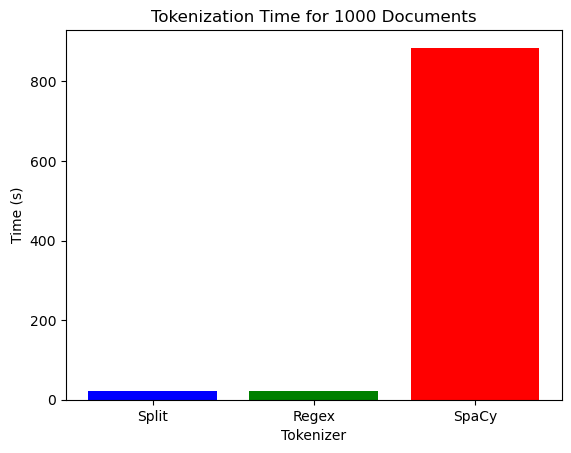

Estimated time for the entire corpus using SplitTokenizer: 4569.40 seconds
Estimated time for the entire corpus using RegexTokenizer: 4622.35 seconds
Estimated time for the entire corpus using SpaCyTokenizer: 176861.43 seconds


In [8]:
'''
Problem 2. (5 points) Using all three document preprocessors, tokenize the first 1000
documents and record the time. Make a plot showing the time taken for each. Using the
average speed per document, estimate how much time it would take to preprocess the entire
corpus and write the estimates in a sentence you submit. Describe the trade-offs you observe
in the tokenizers accuracies and speed and which tokenizer you would use in practice
'''

def time_tokenizer(tokenizer, documents):
    start_time = time.time()
    for doc in tqdm(documents):
        tokenizer.tokenize(doc['text'])
    end_time = time.time()
    return end_time - start_time

# 1. load the multi-word 
mwe_filepath = './data/multi_word_expressions.txt'
mwe_list = []
with open(mwe_filepath, 'r') as f: 
    lines = f.readlines()
    for line in tqdm(lines):
        mwe_list.append(line.strip())
        
split_tokenizer = SplitTokenizer(multiword_expressions=mwe_list)
regex_tokenizer = RegexTokenizer(multiword_expressions=mwe_list)
spacy_tokenizer = SpaCyTokenizer(multiword_expressions=mwe_list)

# 2. read the first 1000 documents from wikipedia_200k_dataset.jsonl
wiki = []
with open('../data/wikipedia_200k_dataset.jsonl') as f:
    for i, line in enumerate(f):
        if i == 1000:
            break
        wiki.append(json.loads(line))
        
split_time = time_tokenizer(split_tokenizer, wiki)
regex_time = time_tokenizer(regex_tokenizer, wiki)
spacy_time = time_tokenizer(spacy_tokenizer, wiki)

# Plot the results
times = [split_time, regex_time, spacy_time]
labels = ['Split', 'Regex', 'SpaCy']
plt.bar(labels, times, color=['blue', 'green', 'red'])
plt.xlabel('Tokenizer')
plt.ylabel('Time (s)')
plt.title('Tokenization Time for 1000 Documents')
plt.show()

# Calculate and print time estimates for the entire corpus
total_documents = 200000  # total number of documents in the corpus
print(f"Estimated time for the entire corpus using SplitTokenizer: {total_documents / 1000 * split_time:.2f} seconds")
print(f"Estimated time for the entire corpus using RegexTokenizer: {total_documents / 1000 * regex_time:.2f} seconds")
print(f"Estimated time for the entire corpus using SpaCyTokenizer: {total_documents / 1000 * spacy_time:.2f} seconds")

##### - Based on the speed_accuracy trade-off, I will choose to use regex tokenizer in the future since it's more accurate than split by space and way more efficient than spacy (which takes 40 times longer)

### Problem 5

In [11]:
'''
(5 points) How efficient are these indices? Let's estimate both the time and
space. Using the RegexPreprocessor, tokenize the first 10,000 documents. Then for each
inverted index implementation, use the Indexer to create an index with the first 10, 100,
1000, and 10000 documents in the collection (what was just preprocessed).
Record (1) how long it took to index that many documents and (2) how much memory the
index consumed. Record these sizes and timestamps. Make a plot for each, showing the
number of documents on the x-axis and either time or memory on the y-axis. Tips: If sizing
the index at each step is taking too long, you can size the index every 1000 steps.
Estimate how big the positional index might get in memory for the entire collection and how
long it would take with that indexer. In a sentence, describe whether you think you could
fit the positional index in memory on your own computer and why.
'''

def time_tokenizer(tokenizer, documents):
    start_time = time.time()
    for doc in tqdm(documents):
        tokenizer.tokenize(doc['text'])
    end_time = time.time()
    return end_time - start_time

# 1. load the multi-word 
mwe_filepath = './data/multi_word_expressions.txt'
mwe_list = []
with open(mwe_filepath, 'r') as f: 
    lines = f.readlines()
    for line in tqdm(lines):
        mwe_list.append(line.strip())
        
regex_tokenizer = RegexTokenizer(multiword_expressions=mwe_list)

# 2. read the first 1000 documents from wikipedia_200k_dataset.jsonl
wiki = []
with open('./data/wikipedia_200k_dataset.jsonl') as f:
    for i, line in enumerate(f):
        if i == 20000:
            break
        wiki.append(json.loads(line))
        
# 3. Tokenize the first 10,000 documents
docid_2_tokens = {}
for doc in tqdm(wiki[:10000]):
    docid_2_tokens[doc['docid']] = regex_tokenizer.tokenize(doc['text'])

# 4. Create the inverted index for the first 10, 100, 1000, and 10000 documents
num_docs = [10, 100, 1000, 10000]

100%|██████████| 10000/10000 [01:47<00:00, 92.65it/s] 


100%|██████████| 4/4 [01:54<00:00, 28.72s/it]


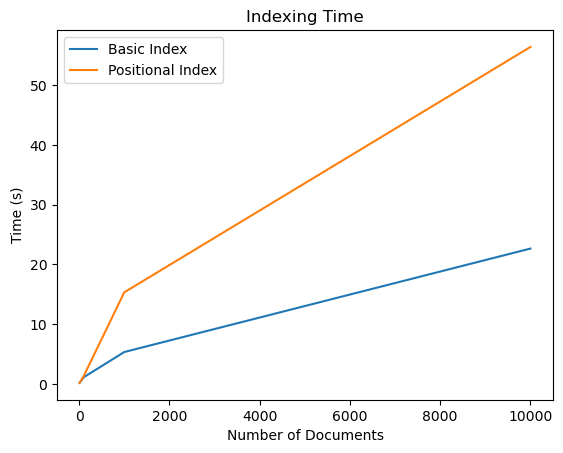

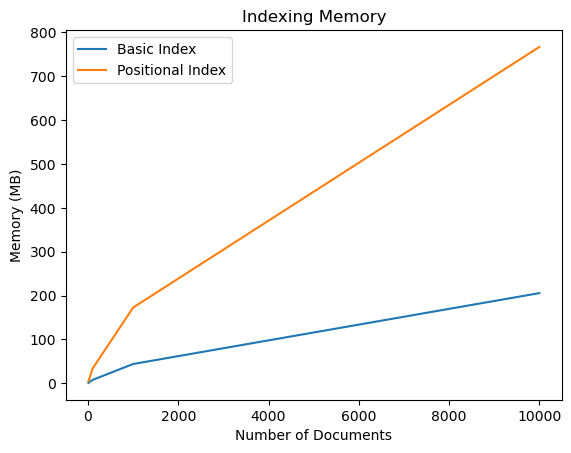

In [42]:
basic_index_times = []
basic_index_memory = []
positional_index_times = []
positional_index_memory = []

for n in tqdm(num_docs):
    # Basic Inverted Index
    basic_index = BasicInvertedIndex()
    start_time = time.time()
    i = 0
    for docid, tokens in docid_2_tokens.items():
        if i == n:
            break
        basic_index.add_doc(docid, tokens)
        i += 1
    end_time = time.time()
    basic_index_times.append(end_time - start_time)
    memory = 0
    for term, info in basic_index.index.items():
        for docid, freq in info.items():
            memory += sys.getsizeof(freq)
    basic_index_memory.append(memory / (1024 ** 2))
    
    # Positional Inverted Index
    positional_index = PositionalInvertedIndex()
    start_time = time.time()
    i = 0
    for docid, tokens in docid_2_tokens.items():
        if i == n:
            break
        positional_index.add_doc(docid, tokens)
        i += 1
    end_time = time.time()
    positional_index_times.append(end_time - start_time)
    memory = 0
    for term, info in positional_index.index.items():
        for docid, freq in info.items():
            memory += sys.getsizeof(freq)
    positional_index_memory.append(memory / (1024 ** 2))
    
# Plot the results
plt.figure()
plt.plot(num_docs, basic_index_times, label='Basic Index')
plt.plot(num_docs, positional_index_times, label='Positional Index')
plt.xlabel('Number of Documents')
plt.ylabel('Time (s)')
plt.title('Indexing Time')
plt.legend()
plt.show()


plt.figure()
plt.plot(num_docs, basic_index_memory, label='Basic Index')
plt.plot(num_docs, positional_index_memory, label='Positional Index')
plt.xlabel('Number of Documents')
plt.ylabel('Memory (MB)')
plt.title('Indexing Memory')
plt.legend()
plt.show()

##### - For the entire collection, the positional index would take around 15GB and 18min to initialize. For my own computer, positional index would be unfeasible to implement since it requires too much in-memory resource. 

### Problem 6
#### (8 points) Implement your own relevance score function and describe how you designed it with respect to the axioms we discussed in lectures/discussion sections. In a few sentences, describe your thought process. It’s okay to have a badly-performing relevance function but we ask you to try to do this task to build some intuition.

#### 1. Thought Process

Term Frequency Axiom: 

    The more frequently a term appears in a document, the more relevant the document is likely to be.

Inverse Document Frequency Axiom: 

    Rare terms in the corpus should carry more weight, as they are more likely to indicate relevance.

Query Coverage Axiom: 

    A document that covers more query terms should have a higher score.

Length Normalization Axiom: 

    Documents should be normalized based on their length to avoid over-penalizing long documents.

Diversity Axiom: 

    Encourage documents that have a good spread of query terms rather than high frequency for just one term.

#### 2. The custom relevance score is calculated using the following formula:

$
\text{Relevance}(Q, D) = \left( \frac{|Q \cap D|}{|Q|} \right) \cdot \sum_{w \in Q \cap D} \left( \frac{tf(w, D)}{|D|} \cdot \left( 1 + \log \left( \frac{N}{df(w)} \right) \right) \right)
$

Where:
- $|Q \cap D|$: The number of unique query terms that appear in the document.
- $|Q|$: The total number of unique terms in the query.
- $tf(w, D)$: Term frequency of word $w$ in document $D$.
- $|D|$: Length of the document $D$ (total number of terms in the document).
- $df(w)$: Document frequency of term $w$ in the corpus.
- $N$: Total number of documents in the corpus.



### Problem 9

In [1]:
from document_preprocessor import RegexTokenizer
from indexing import IndexType, Indexer
from ranker import BM25, PivotedNormalization, TF_IDF, DirichletLM, WordCountCosineSimilarity, Ranker
import relevance
from tqdm import tqdm
import json

wiki_path = './data/wikipedia_200k_dataset.jsonl'
wiki_index_dir = 'wiki_index_dir'
relevance_path = './data/relevance.test.csv'
stopwords_path = './data/stopwords.txt'

In [2]:
stopwords_set = set()
with open(stopwords_path, 'r') as f:
    for line in tqdm(f):
        stopwords_set.add(line.strip())

544it [00:00, ?it/s]


In [3]:
index = Indexer.create_index(IndexType.BasicInvertedIndex, wiki_path, RegexTokenizer('\w+'), stopwords_set, 50, load_file_dir=wiki_index_dir)

Complete loading index!


#### 1. BM25

In [4]:
bm25 = BM25(index)
bm25_ranker = Ranker(index, RegexTokenizer('\w+'), stopwords_set, bm25)
bm25_relevance_test_res = relevance.run_relevance_tests(relevance_path, bm25_ranker)
bm25_relevance_test_res['map'], bm25_relevance_test_res['ndcg']

{54115568: 5, 55140572: 5, 42720: 1, 187749: 4, 30118: 4, 57808: 1, 1203: 5, 215140: 5, 52847: 5, 31793: 5, 17747: 5, 57974: 5, 53787: 5, 89285: 5, 167166: 5, 39937022: 4, 45087245: 4, 47774416: 5, 30655949: 5, 34375483: 5, 31655694: 5, 10983626: 3, 11617636: 3, 14230694: 5, 12427758: 5, 6578583: 5, 9544911: 2, 7783929: 5, 8223762: 5, 7208744: 5, 8008600: 5, 5334607: 3, 3441926: 5, 1952402: 3, 2673795: 5, 2159778: 5, 3266013: 5, 2126097: 5, 2017814: 5, 2176142: 5, 2150513: 5, 1007667: 5}


100%|██████████| 37/37 [00:00<00:00, 705.49it/s]


#### 2. Pivoted Normalization

In [11]:
pivoted_normalization = PivotedNormalization(index)
pivoted_normalization_ranker = Ranker(index, RegexTokenizer('\w+'), stopwords_set, pivoted_normalization)
pivoted_normalization_relevance_test_res = relevance.run_relevance_tests(relevance_path, pivoted_normalization_ranker)
pivoted_normalization_relevance_test_res['map'], pivoted_normalization_relevance_test_res['ndcg']

{54115568: 5, 55140572: 5, 42720: 1, 187749: 4, 30118: 4, 57808: 1, 1203: 5, 215140: 5, 52847: 5, 31793: 5, 17747: 5, 57974: 5, 53787: 5, 89285: 5, 167166: 5, 39937022: 4, 45087245: 4, 47774416: 5, 30655949: 5, 34375483: 5, 31655694: 5, 10983626: 3, 11617636: 3, 14230694: 5, 12427758: 5, 6578583: 5, 9544911: 2, 7783929: 5, 8223762: 5, 7208744: 5, 8008600: 5, 5334607: 3, 3441926: 5, 1952402: 3, 2673795: 5, 2159778: 5, 3266013: 5, 2126097: 5, 2017814: 5, 2176142: 5, 2150513: 5, 1007667: 5}


100%|██████████| 37/37 [00:00<00:00, 709.28it/s]


#### 3. TF-IDF 

In [7]:
tf_idf = TF_IDF(index)
tf_idf_ranker = Ranker(index, RegexTokenizer('\w+'), stopwords_set, tf_idf)
tf_idf_relevance_test_res = relevance.run_relevance_tests(relevance_path, tf_idf_ranker)
tf_idf_relevance_test_res['map'], tf_idf_relevance_test_res['ndcg']

{54115568: 5, 55140572: 5, 42720: 1, 187749: 4, 30118: 4, 57808: 1, 1203: 5, 215140: 5, 52847: 5, 31793: 5, 17747: 5, 57974: 5, 53787: 5, 89285: 5, 167166: 5, 39937022: 4, 45087245: 4, 47774416: 5, 30655949: 5, 34375483: 5, 31655694: 5, 10983626: 3, 11617636: 3, 14230694: 5, 12427758: 5, 6578583: 5, 9544911: 2, 7783929: 5, 8223762: 5, 7208744: 5, 8008600: 5, 5334607: 3, 3441926: 5, 1952402: 3, 2673795: 5, 2159778: 5, 3266013: 5, 2126097: 5, 2017814: 5, 2176142: 5, 2150513: 5, 1007667: 5}


100%|██████████| 37/37 [00:00<00:00, 724.81it/s]


#### 4. Word Count 

In [9]:
word_count_cosine_similarity = WordCountCosineSimilarity(index)
word_count_cosine_similarity_ranker = Ranker(index, RegexTokenizer('\w+'), stopwords_set, word_count_cosine_similarity)
word_count_cosine_similarity_relevance_test_res = relevance.run_relevance_tests(relevance_path, word_count_cosine_similarity_ranker)
word_count_cosine_similarity_relevance_test_res['map'], word_count_cosine_similarity_relevance_test_res['ndcg']

{54115568: 5, 55140572: 5, 42720: 1, 187749: 4, 30118: 4, 57808: 1, 1203: 5, 215140: 5, 52847: 5, 31793: 5, 17747: 5, 57974: 5, 53787: 5, 89285: 5, 167166: 5, 39937022: 4, 45087245: 4, 47774416: 5, 30655949: 5, 34375483: 5, 31655694: 5, 10983626: 3, 11617636: 3, 14230694: 5, 12427758: 5, 6578583: 5, 9544911: 2, 7783929: 5, 8223762: 5, 7208744: 5, 8008600: 5, 5334607: 3, 3441926: 5, 1952402: 3, 2673795: 5, 2159778: 5, 3266013: 5, 2126097: 5, 2017814: 5, 2176142: 5, 2150513: 5, 1007667: 5}


100%|██████████| 37/37 [00:00<00:00, 729.90it/s]
